# Introduction

New York City has a various demography from an ethnical and multicultural point of view. It is the largest city in the United States and it's the home of numerous legal immigrants from all over the world. 

This aim of this final project is to explore the perfect location in order to open a new Chinese restaurant in the city of New York. Chinese restaurants are becoming more and more popular among new yorkers, since they offer an authentic Chinese cusine with affordable prices. This is the reason why opening a new Chinese restaurant is convenient nowadays. However, despite the incredible success asian food is having lately, it's crucial to find the right location for the restaurant, as it contributes for the most part to the success of the restaurant. The question my project wants to answer to is the following: "Where should an investor open a Chinese Restaurant?"

# Data

Collecting data is crucial to answer the above question. Data on New York City must include information about neighborhoods, boroughs, latitude, longitude, restaurants, restaurant ratings and tips. All data regarding neighborhoods and boroughs, latitudes and longitudes can easily be obtained from this dataset: https://cocl.us/new_york_dataset.

On the other hand, all data related to locations and quality of Chinese restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

# Methodology

• Data are collected from the following dataset: https://cocl.us/new_york_dataset. They are cleaned, prepared and processed into a dataframe.

• FourSquare is used to locate all venues and then filtered by Chinese restaurants. Ratings, tips, and likes by users are counted and added to the dataframe.

• Data are sorted based on rankings.

• The last passage regarding data consists in visually assessing using some well known Python libraries.

# Problem Statement

The problem statement is can be easily expressed as: "What are the best locations for a Chinese restaurant in New York?" / "In what Neighborhood should an investor open a Chinese restaurant in order to have success?".

In [51]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [52]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [53]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [54]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [55]:
ny_data.shape

(306, 4)

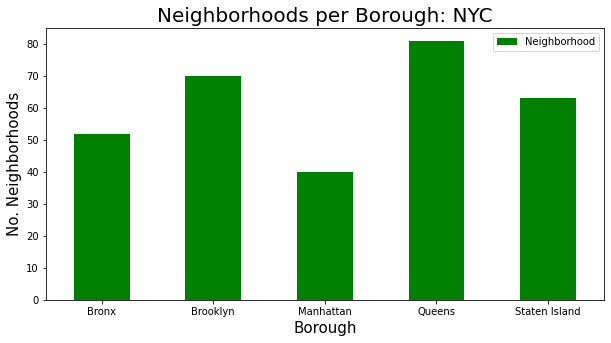

In [56]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [28]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:1
['

( 68 / 306 ) Chinese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Chinese Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Chinese Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Chinese Restaurants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Chinese Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Chinese Restaurants in East New York, Brooklyn:2
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Chinese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Chinese Restaurants in Canarsie, Brooklyn:1
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269

( 131 / 306 ) Chinese Restaurants in Woodside, Queens:1
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Chinese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Chinese Restaurants in Elmhurst, Queens:2
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Chinese Restaurants in Howard Beach, Queens:2
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Chinese Restaurants in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Chinese Restaurants in Forest Hills, Queens:1
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Chinese Restaurants in Kew Gardens, Queens:2
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Chinese Restaurants in Richmond Hill, Queens:1
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) C

( 198 / 306 ) Chinese Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Chinese Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Chinese Restaurants in Stapleton, Staten Island:1
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Chinese Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Chinese Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Chinese Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Chinese Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Chinese Restaurants in South Bea

( 259 / 306 ) Chinese Restaurants in Elm Park, Staten Island:1
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Chinese Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Chinese Restaurants in New Lots, Brooklyn:2
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Chinese Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Chinese Restaurants in Mill Basin, Brooklyn:2
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Chinese Restaurants in Jamaica Hills, Queens:1
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Chinese Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Chinese Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120

In [29]:
# Save the information so far to a .csv file due to limited calls on FourSquare
chinese_rest_ny.to_csv('chinese_rest_ny.csv')

In [57]:
chinese_ny = pd.read_csv('chinese_rest_ny.csv')
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
180,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
181,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
182,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
183,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
184,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


In [58]:
chinese_rest_ny.shape

(185, 4)

We got 185 Chinese Restaurants in New York City.

As we continue our analysis, we see below that Brooklymn and Qeens, which have the highest number of neighborhoods, have also the highest number of Chinese restaurants. This may us think that Chinese restaurants do follow the urban/morphological distribution of the city. Additionally, we see how many restaurants the top 5 neighborhoods have. The neighborhood of Chinatown has the highest number of Chinese restaurants, as expected, in all of NYC, but all the top 5 are located in Manhattan, Brooklyn or Queens.

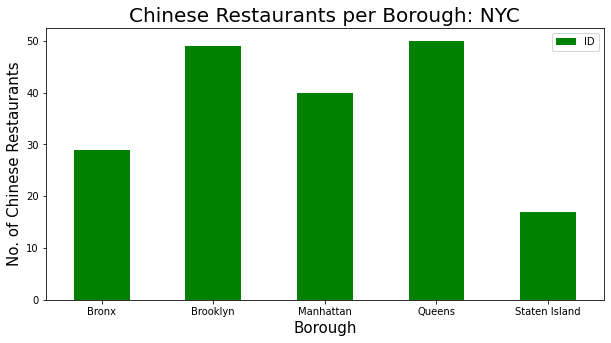

In [59]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

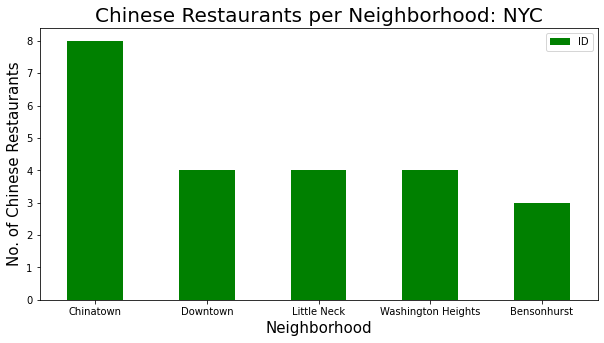

In [60]:
NOofNeigh = 5 # top number for graphing all the same past 5
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [61]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
61,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
62,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
63,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
64,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
65,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
66,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
67,Manhattan,Chinatown,3fd66200f964a520ede41ee3,Big Wong King 大旺
68,Manhattan,Chinatown,3fd66200f964a520ceea1ee3,Deluxe Green Bo Restaurant


In [62]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
print(chinese_rest_stats_ny.isnull().sum())
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()

Borough         0
Neighborhood    0
ID              0
Name            0
Likes           0
Rating          0
Tips            0
dtype: int64
{'meta': {'code': 200, 'requestId': '604f3948905915231a161bad'}, 'response': {'venue': {'id': '4c9d5f2654c8a1cd2e71834b', 'name': 'Guang Hui Chinese Restaurant', 'contact': {'phone': '7188623288', 'formattedPhone': '(718) 862-3288'}, 'location': {'address': '125 Dreiser Loop', 'lat': 40.876651, 'lng': -73.829092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.876651, 'lng': -73.829092}, {'label': 'entrance', 'lat': 40.876084, 'lng': -73.829209}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 Dreiser Loop', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/guang-hui-chinese-restaurant/4c9d5f2654c8a1cd2e71834b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chin

{'meta': {'code': 200, 'requestId': '604f394887abb81d40c0fc1c'}, 'response': {'venue': {'id': '4e41d2c4b61ca5ba3b1f9c6b', 'name': 'Ming Liang Kitchen', 'contact': {'phone': '71854707780779', 'formattedPhone': '71854707780779'}, 'location': {'address': '236 E Gun Hill Rd', 'crossStreet': 'Kings College Place', 'lat': 40.879876, 'lng': -73.87662900000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879876, 'lng': -73.87662900000001}, {'label': 'entrance', 'lat': 40.879844, 'lng': -73.87664}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['236 E Gun Hill Rd (Kings College Place)', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ming-liang-kitchen/4e41d2c4b61ca5ba3b1f9c6b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',

{'meta': {'code': 200, 'requestId': '604f394956b7ae7d6adc5b99'}, 'response': {'venue': {'id': '4bc8f646b6c49c74d8898d91', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '7188282225', 'formattedPhone': '(718) 828-2225'}, 'location': {'address': '2049 Williamsbridge Rd', 'lat': 40.855168, 'lng': -73.855587, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855168, 'lng': -73.855587}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2049 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4bc8f646b6c49c74d8898d91', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'http://www.grea

{'meta': {'code': 200, 'requestId': '604f394a6841db0efd77cb5e'}, 'response': {'venue': {'id': '4cf30a837e93f04d366a5669', 'name': 'China Wok II', 'contact': {'phone': '7185842488', 'formattedPhone': '(718) 584-2488'}, 'location': {'address': '2459 Webster Ave', 'crossStreet': '188th street', 'lat': 40.860219, 'lng': -73.893323, 'labeledLatLngs': [{'label': 'display', 'lat': 40.860219, 'lng': -73.893323}, {'label': 'entrance', 'lat': 40.860154, 'lng': -73.893174}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2459 Webster Ave (188th street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-wok-ii/4cf30a837e93f04d366a5669', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '604f394c9230861b295c3502'}, 'response': {'venue': {'id': '4da0c70b7aee5481bda6b2fe', 'name': 'wah yong', 'contact': {}, 'location': {'address': '112 W 168th St', 'crossStreet': 'nelson ave', 'lat': 40.83821105957031, 'lng': -73.92478942871094, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.838237, 'lng': -73.92469}, {'label': 'display', 'lat': 40.83821105957031, 'lng': -73.92478942871094}], 'postalCode': '10452', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['112 W 168th St (nelson ave)', 'Bronx, NY 10452', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-yong/4da0c70b7aee5481bda6b2fe', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'pric

{'meta': {'code': 200, 'requestId': '604f394e62d9b434d7b01961'}, 'response': {'venue': {'id': '4d8c0a6e9f3fb1f7f646ffbc', 'name': 'Little Chopsticks Kitchen', 'contact': {'phone': '7188603288', 'formattedPhone': '(718) 860-3288'}, 'location': {'address': '959 Leggett Ave', 'lat': 40.815405, 'lng': -73.90001099999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.815405, 'lng': -73.90001099999999}, {'label': 'entrance', 'lat': 40.815317, 'lng': -73.900078}], 'postalCode': '10455', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['959 Leggett Ave', 'Bronx, NY 10455', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-chopsticks-kitchen/4d8c0a6e9f3fb1f7f646ffbc', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

{'meta': {'code': 200, 'requestId': '604f395056b7ae7d6adc6c9a'}, 'response': {'venue': {'id': '4b89b62df964a520ff4c32e3', 'name': 'Sabor Latino Seafood Restaurant', 'contact': {'phone': '7188220899', 'formattedPhone': '(718) 822-0899'}, 'location': {'address': '2161 Starling Ave', 'crossStreet': 'at Purdy St', 'lat': 40.83636550185743, 'lng': -73.85303360278897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83636550185743, 'lng': -73.85303360278897}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2161 Starling Ave (at Purdy St)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sabor-latino-seafood-restaurant/4b89b62df964a520ff4c32e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '604f395124641a240f87aa18'}, 'response': {'venue': {'id': '4cacb18b44a8224bb2c23540', 'name': 'Oriental House', 'contact': {'phone': '7185638888', 'formattedPhone': '(718) 563-8888'}, 'location': {'address': '565 E 184th St', 'crossStreet': '3rd Ave.', 'lat': 40.85469436645508, 'lng': -73.8900375366211, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85469436645508, 'lng': -73.8900375366211}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['565 E 184th St (3rd Ave.)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oriental-house/4cacb18b44a8224bb2c23540', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, '

{'meta': {'code': 200, 'requestId': '604f39537c789a545739330e'}, 'response': {'venue': {'id': '4b5f3d97f964a52074af29e3', 'name': 'Lee Xing', 'contact': {'phone': '7188297945', 'formattedPhone': '(718) 829-7945'}, 'location': {'address': '3207 Westchester Ave', 'lat': 40.851829528808594, 'lng': -73.82991027832031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.851829528808594, 'lng': -73.82991027832031}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3207 Westchester Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lee-xing/4b5f3d97f964a52074af29e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Ch

{'meta': {'code': 200, 'requestId': '604f3954222e3f1aecd66c5c'}, 'response': {'venue': {'id': '4eadecbf9911d5c95181ee84', 'name': 'Yummy House', 'contact': {'phone': '9177836777', 'formattedPhone': '(917) 783-6777'}, 'location': {'address': '2452 Eastchester Rd', 'crossStreet': 'Mace Ave.', 'lat': 40.86249, 'lng': -73.843079, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86249, 'lng': -73.843079}, {'label': 'entrance', 'lat': 40.862476, 'lng': -73.843227}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2452 Eastchester Rd (Mace Ave.)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yummy-house/4eadecbf9911d5c95181ee84', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '604f39551d22ba42e7075b7e'}, 'response': {'venue': {'id': '4e1a1a3252b123a586e6db52', 'name': 'Eastern Chinese Style', 'contact': {'phone': '7182935194', 'formattedPhone': '(718) 293-5194'}, 'location': {'address': '1233 Grant Ave', 'crossStreet': '167 Street', 'lat': 40.833852000709385, 'lng': -73.91496116426204, 'labeledLatLngs': [{'label': 'display', 'lat': 40.833852000709385, 'lng': -73.91496116426204}, {'label': 'entrance', 'lat': 40.833922, 'lng': -73.914899}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1233 Grant Ave (167 Street)', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/eastern-chinese-style/4e1a1a3252b123a586e6db52', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 's

{'meta': {'code': 200, 'requestId': '604f3956aa67e67eb87d4617'}, 'response': {'venue': {'id': '4c6702e98e9120a1a3a1d964', 'name': 'Pearl of China', 'contact': {'phone': '7188334281', 'formattedPhone': '(718) 833-4281'}, 'location': {'address': '8411 3rd Ave', 'crossStreet': 'at 85th St.', 'lat': 40.624631, 'lng': -74.030301, 'labeledLatLngs': [{'label': 'display', 'lat': 40.624631, 'lng': -74.030301}, {'label': 'entrance', 'lat': 40.62466, 'lng': -74.030418}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8411 3rd Ave (at 85th St.)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pearl-of-china/4c6702e98e9120a1a3a1d964', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified

{'meta': {'code': 200, 'requestId': '604f3958840f4109d7c72718'}, 'response': {'venue': {'id': '4bd60f4c4e32d13a6000c280', 'name': 'Taste Of China', 'contact': {'phone': '7182563838', 'formattedPhone': '(718) 256-3838'}, 'location': {'address': '7824 20th Ave', 'crossStreet': 'at 79th St.', 'lat': 40.608834, 'lng': -73.994117, 'labeledLatLngs': [{'label': 'display', 'lat': 40.608834, 'lng': -73.994117}, {'label': 'entrance', 'lat': 40.608729, 'lng': -73.99415}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7824 20th Ave (at 79th St.)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taste-of-china/4bd60f4c4e32d13a6000c280', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '604f3959468dc25ca7f9993f'}, 'response': {'venue': {'id': '4d7171341c01b60ccebe14c7', 'name': 'Nueva Victoria Restaurant', 'contact': {'phone': '7184312938', 'formattedPhone': '(718) 431-2938', 'twitter': 'newvictory'}, 'location': {'address': '4803 5th Ave', 'lat': 40.645984999999996, 'lng': -74.009117, 'labeledLatLngs': [{'label': 'display', 'lat': 40.645984999999996, 'lng': -74.009117}, {'label': 'entrance', 'lat': 40.646028, 'lng': -74.009181}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4803 5th Ave', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nueva-victoria-restaurant/4d7171341c01b60ccebe14c7', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prima

{'meta': {'code': 200, 'requestId': '604f395bc1c49a0429e65878'}, 'response': {'venue': {'id': '4c257346c9bbef3ba975afac', 'name': 'Tasty House', 'contact': {'phone': '7183720006', 'formattedPhone': '(718) 372-0006'}, 'location': {'address': '253 Avenue U', 'crossStreet': 'Van Sicklen St', 'lat': 40.59701, 'lng': -73.974715, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59701, 'lng': -73.974715}, {'label': 'entrance', 'lat': 40.596924, 'lng': -73.974726}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['253 Avenue U (Van Sicklen St)', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tasty-house/4c257346c9bbef3ba975afac', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '604f395d48180a6217824e48'}, 'response': {'venue': {'id': '54e39b14498e9c646b42958e', 'name': 'East Wind Snack Shop', 'contact': {'phone': '9292950188', 'formattedPhone': '(929) 295-0188'}, 'location': {'address': '471 16th St', 'crossStreet': 'at Prospect Park West', 'lat': 40.660297, 'lng': -73.980169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660297, 'lng': -73.980169}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['471 16th St (at Prospect Park West)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-wind-snack-shop/54e39b14498e9c646b42958e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '604f395d95476b2db222ddd7'}, 'response': {'venue': {'id': '4c06e2470e0a2d7fdf8aec0c', 'name': '#1 Garden Chinese Food', 'contact': {'phone': '7188321795', 'formattedPhone': '(718) 832-1795'}, 'location': {'address': '221 Prospect Park W', 'lat': 40.660248811093595, 'lng': -73.98054235147856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660248811093595, 'lng': -73.98054235147856}, {'label': 'entrance', 'lat': 40.660106, 'lng': -73.980445}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/1-garden-chinese-food/4c06e2470e0a2d7fdf8aec0c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '604f395e95476b2db222e05e'}, 'response': {'venue': {'id': '4a9ac078f964a5207c3220e3', 'name': 'Fortune House', 'contact': {'phone': '7188557055', 'formattedPhone': '(718) 855-7055'}, 'location': {'address': '82 Henry St', 'crossStreet': 'btwn Pineapple & Orange St', 'lat': 40.698411434008214, 'lng': -73.99254201285272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698411434008214, 'lng': -73.99254201285272}, {'label': 'entrance', 'lat': 40.69842, 'lng': -73.992688}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82 Henry St (btwn Pineapple & Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fortune-house/4a9ac078f964a5207c3220e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '604f395f7bc2ec28dee43dcb'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '604f3960c0470e3e31043fbd'}, 'response': {'venue': {'id': '4b09dc38f964a520cf1e23e3', 'name': 'Ting Hua', 'contact': {'phone': '7188526287', 'formattedPhone': '(718) 852-6287'}, 'location': {'address': '351 Smith St', 'crossStreet': 'at Carroll St.', 'lat': 40.6799366374633, 'lng': -73.99512985321104, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6799366374633, 'lng': -73.99512985321104}, {'label': 'entrance', 'lat': 40.679872, 'lng': -73.994989}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['351 Smith St (at Carroll St.)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ting-hua/4b09dc38f964a520cf1e23e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '604f3961ccb5ce3c753aaf94'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '604f39625c9e642459674efa'}, 'response': {'venue': {'id': '4c818737d8086dcb1c0f6e52', 'name': 'Wah On', 'contact': {'phone': '7183481730', 'formattedPhone': '(718) 348-1730'}, 'location': {'address': '986 Sutter Ave', 'crossStreet': 'Linwood', 'lat': 40.671129, 'lng': -73.882306, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671129, 'lng': -73.882306}, {'label': 'entrance', 'lat': 40.67119, 'lng': -73.882322}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['986 Sutter Ave (Linwood)', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-on/4c818737d8086dcb1c0f6e52', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '604f396397d24e3f5eade9f5'}, 'response': {'venue': {'id': '4c0d470bb1b676b02558e086', 'name': 'Eastern Chinese Restaurant', 'contact': {'phone': '7189468888', 'formattedPhone': '(718) 946-8888'}, 'location': {'address': '2008 Cropsey Ave', 'lat': 40.599751, 'lng': -74.002672, 'labeledLatLngs': [{'label': 'display', 'lat': 40.599751, 'lng': -74.002672}, {'label': 'entrance', 'lat': 40.599899, 'lng': -74.002667}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2008 Cropsey Ave', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/eastern-chinese-restaurant/4c0d470bb1b676b02558e086', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '604f39651d22ba42e7078269'}, 'response': {'venue': {'id': '59da9590e1f0aa52976b8f35', 'name': 'Han Dynasty', 'contact': {}, 'location': {'address': '445 Albee Sq', 'crossStreet': 'Fleet St', 'lat': 40.691333919005594, 'lng': -73.98245632424464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.691333919005594, 'lng': -73.98245632424464}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq (Fleet St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/59da9590e1f0aa52976b8f35', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'short

{'meta': {'code': 200, 'requestId': '604f396676b371362acfddb0'}, 'response': {'venue': {'id': '5db3649a8d15ba00089b4e9b', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '54 Willoughby St', 'lat': 40.69217, 'lng': -73.98673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69217, 'lng': -73.98673}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 Willoughby St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5db3649a8d15ba00089b4e9b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 11, 'groups': [{'type': 'others', '

{'meta': {'code': 200, 'requestId': '604f396740460b6346f48c95'}, 'response': {'venue': {'id': '5b7f3e462aff31002ce1bdc4', 'name': '100% Mr Lin', 'contact': {}, 'location': {'address': '445 Albee Sq W', 'lat': 40.69126720493811, 'lng': -73.9829421043396, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69126720493811, 'lng': -73.9829421043396}], 'postalCode': '11201', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq W', 'New York, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/100-mr-lin/5b7f3e462aff31002ce1bdc4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 5, 'groups': [{'typ

{'meta': {'code': 200, 'requestId': '604f3968d1563c0334b5c413'}, 'response': {'venue': {'id': '4f4464ed19836ed00193d4a6', 'name': 'Good Taste Chinese Restaurant', 'contact': {'phone': '7184856868', 'formattedPhone': '(718) 485-6868'}, 'location': {'address': '126 Hull St', 'lat': 40.679237, 'lng': -73.910843, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679237, 'lng': -73.910843}, {'label': 'entrance', 'lat': 40.679221, 'lng': -73.9109}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['126 Hull St', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-taste-chinese-restaurant/4f4464ed19836ed00193d4a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '604f396ad34f6c62afcfdd9a'}, 'response': {'venue': {'id': '54b318a1498eb29e9541053a', 'name': 'Wei Williamsburg', 'contact': {'phone': '7183601908', 'formattedPhone': '(718) 360-1908', 'twitter': 'williamsburgwei'}, 'location': {'address': '145 Borinquen Pl', 'crossStreet': 'Keap Street', 'lat': 40.71067589705568, 'lng': -73.95403239442538, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71067589705568, 'lng': -73.95403239442538}, {'label': 'entrance', 'lat': 40.710819, 'lng': -73.953903}], 'postalCode': '11211', 'cc': 'US', 'neighborhood': 'South Williamsburg', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['145 Borinquen Pl (Keap Street)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wei-williamsburg/54b318a1498eb29e9541053a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '604f396a9230861b295c7e0e'}, 'response': {'venue': {'id': '4b512cbaf964a520f64527e3', 'name': 'ha ha chinese', 'contact': {'phone': '7188338078', 'formattedPhone': '(718) 833-8078'}, 'location': {'address': '9212 4th Ave', 'crossStreet': '92nd + 93rd and 4th ave', 'lat': 40.618022230237116, 'lng': -74.03030968368607, 'labeledLatLngs': [{'label': 'display', 'lat': 40.618022230237116, 'lng': -74.03030968368607}, {'label': 'entrance', 'lat': 40.618092, 'lng': -74.030468}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9212 4th Ave (92nd + 93rd and 4th ave)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ha-ha-chinese/4b512cbaf964a520f64527e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '604f396cd1563c0334b5cc90'}, 'response': {'venue': {'id': '4cb0fb23eb65b1f7c61871cd', 'name': 'Panda Garden', 'contact': {'phone': '7186801126', 'formattedPhone': '(718) 680-1126'}, 'location': {'address': '9708 3rd Ave', 'lat': 40.615772172484405, 'lng': -74.03427146686259, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615772172484405, 'lng': -74.03427146686259}, {'label': 'entrance', 'lat': 40.615751, 'lng': -74.034365}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9708 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-garden/4cb0fb23eb65b1f7c61871cd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '604f396cccb5ce3c753ac9b6'}, 'response': {'venue': {'id': '4a96bf8ff964a520ce2620e3', 'name': 'Wah Fung Number 1 Fast Food 華豐快餐店', 'contact': {'phone': '2129255175', 'formattedPhone': '(212) 925-5175'}, 'location': {'address': '79 Chrystie St', 'crossStreet': 'btwn Hester St & Grand St', 'lat': 40.71727831655619, 'lng': -73.99417731304892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71727831655619, 'lng': -73.99417731304892}, {'label': 'entrance', 'lat': 40.717303, 'lng': -73.994439}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79 Chrystie St (btwn Hester St & Grand St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-fung-number-1-fast-food-%E8%8F%AF%E8%B1%90%E5%BF%AB%E9%A4%90%E5%BA%97/4a96bf8ff964a520ce2620e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', '

{'meta': {'code': 200, 'requestId': '604f396db967997a39204c15'}, 'response': {'venue': {'id': '5894c9a15e56b417cf79e553', 'name': "Xi'an Famous Foods", 'contact': {'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '45 Bayard St', 'crossStreet': 'Bowery', 'lat': 40.715231941715004, 'lng': -73.99726288220869, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715231941715004, 'lng': -73.99726288220869}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Bayard St (Bowery)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5894c9a15e56b417cf79e553', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

{'meta': {'code': 200, 'requestId': '604f396e62d9b434d7b062e3'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '604f396e4cf2d83b445ded67'}, 'response': {'venue': {'id': '59d828f0916bc1155fde2c04', 'name': 'Hwa Yuan', 'contact': {'phone': '2129666002', 'formattedPhone': '(212) 966-6002', 'instagram': 'hwa.yuan.nyc', 'facebook': '463197850727690', 'facebookUsername': 'HwaYuanNYC', 'facebookName': 'Hwa Yuan 華園'}, 'location': {'address': '42 E Broadway', 'lat': 40.713618266530226, 'lng': -73.99597818966741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.713618266530226, 'lng': -73.99597818966741}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42 E Broadway', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hwa-yuan/59d828f0916bc1155fde2c04', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', '

{'meta': {'code': 200, 'requestId': '604f396e905915231a167939'}, 'response': {'venue': {'id': '3fd66200f964a520b1ea1ee3', 'name': 'Great N.Y. Noodletown', 'contact': {'phone': '2123490923', 'formattedPhone': '(212) 349-0923'}, 'location': {'address': '28 Bowery', 'crossStreet': 'btwn Pell & Bayard St', 'lat': 40.715039001656855, 'lng': -73.99694075378208, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715039001656855, 'lng': -73.99694075378208}, {'label': 'entrance', 'lat': 40.714988, 'lng': -73.997055}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28 Bowery (btwn Pell & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-ny-noodletown/3fd66200f964a520b1ea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '604f396fb967997a392050b0'}, 'response': {'venue': {'id': '3fd66200f964a520ede41ee3', 'name': 'Big Wong King 大旺', 'contact': {'phone': '2129640540', 'formattedPhone': '(212) 964-0540', 'facebook': '113401808693731', 'facebookName': 'Big Wong Restaurant'}, 'location': {'address': '67 Mott St', 'crossStreet': 'btwn Canal St & Bayard St', 'lat': 40.71619620821637, 'lng': -73.99830311536789, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71619620821637, 'lng': -73.99830311536789}, {'label': 'entrance', 'lat': 40.716179, 'lng': -73.998251}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['67 Mott St (btwn Canal St & Bayard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/big-wong-king-%E5%A4%A7%E6%97%BA/3fd66200f964a520ede41ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants

{'meta': {'code': 200, 'requestId': '604f39717c789a54573978c8'}, 'response': {'venue': {'id': '3fd66200f964a520ceea1ee3', 'name': 'Deluxe Green Bo Restaurant', 'contact': {'phone': '2126252359', 'formattedPhone': '(212) 625-2359', 'twitter': 'deluxegreenbo'}, 'location': {'address': '66 Bayard St', 'crossStreet': 'btwn Elizabeth & Mott St', 'lat': 40.715544918133155, 'lng': -73.99813747002635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715544918133155, 'lng': -73.99813747002635}, {'label': 'entrance', 'lat': 40.715543, 'lng': -73.998033}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66 Bayard St (btwn Elizabeth & Mott St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/deluxe-green-bo-restaurant/3fd66200f964a520ceea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '604f3971b2d4e616c5ea1540'}, 'response': {'venue': {'id': '4b292f38f964a520939a24e3', 'name': 'Yang Garden', 'contact': {'phone': '2127810055', 'formattedPhone': '(212) 781-0055', 'twitter': 'yang187garden'}, 'location': {'address': '816 W 187th St', 'crossStreet': 'Pinehurst', 'lat': 40.85530896752232, 'lng': -73.93783226069496, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85530896752232, 'lng': -73.93783226069496}, {'label': 'entrance', 'lat': 40.855266, 'lng': -73.937644}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['816 W 187th St (Pinehurst)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yang-garden/4b292f38f964a520939a24e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/a

{'meta': {'code': 200, 'requestId': '604f3972c0470e3e31046ba0'}, 'response': {'venue': {'id': '4b3fe94af964a520e2b125e3', 'name': 'No. 1 Chinese Restaurant', 'contact': {'phone': '2127403188', 'formattedPhone': '(212) 740-3188'}, 'location': {'address': '825 W 181st St', 'crossStreet': 'Pinehurst Avenue', 'lat': 40.85123671099152, 'lng': -73.93960586750859, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85123671099152, 'lng': -73.93960586750859}, {'label': 'entrance', 'lat': 40.851353, 'lng': -73.93946}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['825 W 181st St (Pinehurst Avenue)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/no-1-chinese-restaurant/4b3fe94af964a520e2b125e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '604f397362d9b434d7b070ce'}, 'response': {'venue': {'id': '4aaed36bf964a520736320e3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '2127959379', 'formattedPhone': '(212) 795-9379', 'twitter': 'thegreatwallma'}, 'location': {'address': '800 W 181st St', 'crossStreet': 'at Fort Washington Ave', 'lat': 40.85085901713292, 'lng': -73.93834216873442, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85085901713292, 'lng': -73.93834216873442}, {'label': 'entrance', 'lat': 40.850859, 'lng': -73.938504}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['800 W 181st St (at Fort Washington Ave)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4aaed36bf964a520736320e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '604f3974705bdd2260f4aa87'}, 'response': {'venue': {'id': '4b9aeeedf964a52086e435e3', 'name': 'Lotus Express', 'contact': {'phone': '2125698899', 'formattedPhone': '(212) 569-8899'}, 'location': {'address': '4840 Broadway', 'lat': 40.866279999999996, 'lng': -73.92456700000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866279999999996, 'lng': -73.92456700000001}, {'label': 'entrance', 'lat': 40.866326, 'lng': -73.924612}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4840 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lotus-express/4b9aeeedf964a52086e435e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '604f39767c676a3ae118a95b'}, 'response': {'venue': {'id': '4bd1f6909854d13a38a2fa4d', 'name': '88 Chinese Restaurant', 'contact': {'phone': '2122811288', 'formattedPhone': '(212) 281-1288'}, 'location': {'address': '473 Malcolm X Blvd', 'crossStreet': 'at W 133rd St', 'lat': 40.81318684305849, 'lng': -73.94146699347901, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81318684305849, 'lng': -73.94146699347901}, {'label': 'entrance', 'lat': 40.813351, 'lng': -73.941723}], 'postalCode': '10037', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['473 Malcolm X Blvd (at W 133rd St)', 'New York, NY 10037', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/88-chinese-restaurant/4bd1f6909854d13a38a2fa4d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '604f3977aa67e67eb87d94db'}, 'response': {'venue': {'id': '5465906e498e0cb221c063e1', 'name': 'Pig Heaven', 'contact': {'phone': '2127444333', 'formattedPhone': '(212) 744-4333', 'facebook': '1673948389361231', 'facebookUsername': 'pigheavennyc', 'facebookName': 'Pig Heaven'}, 'location': {'address': '1420 3rd Ave', 'crossStreet': '81st', 'lat': 40.7754503, 'lng': -73.95683919999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7754503, 'lng': -73.95683919999999}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1420 3rd Ave (81st)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pig-heaven/5465906e498e0cb221c063e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '604f39782318c6252224c2b5'}, 'response': {'venue': {'id': '4ea5be4af5b9efc002cccdea', 'name': 'Shanghai', 'contact': {'phone': '2122888067', 'formattedPhone': '(212) 288-8067'}, 'location': {'address': '1388 2nd Ave', 'crossStreet': 'btwn 71st & 72nd St', 'lat': 40.768334, 'lng': -73.958493, 'labeledLatLngs': [{'label': 'display', 'lat': 40.768334, 'lng': -73.958493}, {'label': 'entrance', 'lat': 40.768342, 'lng': -73.958499}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1388 2nd Ave (btwn 71st & 72nd St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shanghai/4ea5be4af5b9efc002cccdea', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '604f3978c6a95143637ac45b'}, 'response': {'venue': {'id': '56759406498ecd2d68a85eec', 'name': 'Panda Express', 'contact': {}, 'location': {'lat': 40.76566581236336, 'lng': -73.95745129061507, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76566581236336, 'lng': -73.95745129061507}, {'label': 'entrance', 'lat': 40.76577, 'lng': -73.957687}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-express/56759406498ecd2d68a85eec', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 

{'meta': {'code': 200, 'requestId': '604f39794cf2d83b445e0666'}, 'response': {'venue': {'id': '5529bfd8498ec6ce692d8015', 'name': 'Han Dynasty', 'contact': {'phone': '2128589060', 'formattedPhone': '(212) 858-9060'}, 'location': {'address': '215 W 85th St', 'crossStreet': 'at Broadway', 'lat': 40.78761996790675, 'lng': -73.97635945297974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78761996790675, 'lng': -73.97635945297974}], 'postalCode': '10024', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['215 W 85th St (at Broadway)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/5529bfd8498ec6ce692d8015', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '604f397a7bc2ec28dee47c90'}, 'response': {'venue': {'id': '557c79d2498e5325b3ee05fe', 'name': 'Mah Jong', 'contact': {'phone': '2125862000', 'formattedPhone': '(212) 586-2000'}, 'location': {'address': '35 W End Ave', 'crossStreet': 'btwn W 61st & 62nd Sts', 'lat': 40.773425, 'lng': -73.989621, 'labeledLatLngs': [{'label': 'display', 'lat': 40.773425, 'lng': -73.989621}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['35 W End Ave (btwn W 61st & 62nd Sts)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mah-jong/557c79d2498e5325b3ee05fe', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restauran

{'meta': {'code': 200, 'requestId': '604f397bccb5ce3c753aeb0e'}, 'response': {'venue': {'id': '4e3484038877beb5e9a22a0b', 'name': 'Café China', 'contact': {'phone': '2122132810', 'formattedPhone': '(212) 213-2810', 'twitter': 'cafechina_nyc', 'facebook': '114524875291105', 'facebookUsername': 'cafechina', 'facebookName': 'Cafe  China    傾 城'}, 'location': {'address': '13 E 37th St', 'crossStreet': 'btwn 5th Ave & Madison Ave', 'lat': 40.7499796904135, 'lng': -73.98223427700086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7499796904135, 'lng': -73.98223427700086}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Garment District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 37th St (btwn 5th Ave & Madison Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-china/4e3484038877beb5e9a22a0b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Ch

{'meta': {'code': 200, 'requestId': '604f397b62d9b434d7b083a9'}, 'response': {'venue': {'id': '44e9b421f964a520a5371fe3', 'name': 'Buddakan', 'contact': {'phone': '2129896699', 'formattedPhone': '(212) 989-6699', 'facebook': '120232901321722', 'facebookUsername': 'buddakannyc', 'facebookName': 'Buddakan'}, 'location': {'address': '75 9th Ave', 'crossStreet': 'at W 16th St', 'lat': 40.74211957525603, 'lng': -74.00461189502685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74211957525603, 'lng': -74.00461189502685}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 9th Ave (at W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/buddakan/44e9b421f964a520a5371fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asi

{'meta': {'code': 200, 'requestId': '604f397c5c85a33ad7ab0605'}, 'response': {'venue': {'id': '5a20df1742d8c2528e74211f', 'name': 'Chow House', 'contact': {'phone': '2128371021', 'formattedPhone': '(212) 837-1021'}, 'location': {'address': '181 Bleecker St', 'crossStreet': 'btwn MacDougal & Sullivan St', 'lat': 40.72906152574308, 'lng': -74.00084246972851, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72906152574308, 'lng': -74.00084246972851}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 Bleecker St (btwn MacDougal & Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chow-house/5a20df1742d8c2528e74211f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id'

{'meta': {'code': 200, 'requestId': '604f397d67449f0c9df5473c'}, 'response': {'venue': {'id': '5b36566f666116002c6b265e', 'name': 'Junzi Kitchen', 'contact': {'phone': '6468640277', 'formattedPhone': '(646) 864-0277', 'twitter': 'junzikitchen', 'instagram': 'junzikitchen'}, 'location': {'address': '170 Bleecker St', 'crossStreet': 'at Sullivan St', 'lat': 40.72876711130392, 'lng': -74.00053543555785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72876711130392, 'lng': -74.00053543555785}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 Bleecker St (at Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/junzi-kitchen/5b36566f666116002c6b265e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix'

{'meta': {'code': 200, 'requestId': '604f397f5c85a33ad7ab0caa'}, 'response': {'venue': {'id': '5b0078680ff4f9002c1c94bd', 'name': 'Dian Kitchen', 'contact': {}, 'location': {'address': '435 E 9th St', 'crossStreet': 'Ave A', 'lat': 40.72752385640814, 'lng': -73.9832675757664, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72752385640814, 'lng': -73.9832675757664}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['435 E 9th St (Ave A)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dian-kitchen/5b0078680ff4f9002c1c94bd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': '

{'meta': {'code': 200, 'requestId': '604f397fd6dbbd0b3d2a3c64'}, 'response': {'venue': {'id': '5c831f04029a550039fcca38', 'name': 'Chinese Graffiti', 'contact': {}, 'location': {'address': '171 Avenue A', 'lat': 40.728282, 'lng': -73.981952, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728282, 'lng': -73.981952}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 Avenue A', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chinese-graffiti/5c831f04029a550039fcca38', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count':

{'meta': {'code': 200, 'requestId': '604f3980905915231a16a215'}, 'response': {'venue': {'id': '5b380f649deb7d00399fdf9d', 'name': 'Kings County Imperial', 'contact': {'phone': '2124750244', 'formattedPhone': '(212) 475-0244'}, 'location': {'address': '168 1/2 Delancey St', 'crossStreet': 'btw Clinton & Attorney', 'lat': 40.71781670552335, 'lng': -73.98556881621373, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71781670552335, 'lng': -73.98556881621373}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168 1/2 Delancey St (btw Clinton & Attorney)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-county-imperial/5b380f649deb7d00399fdf9d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '604f3981840f4109d7c787fe'}, 'response': {'venue': {'id': '5d9b6bef309f4b000893454d', 'name': '3 Times', 'contact': {'phone': '6466096324', 'formattedPhone': '(646) 609-6324', 'instagram': 'eat3times', 'facebook': '112287750121624', 'facebookUsername': '3timesnyc', 'facebookName': '3 Times 茅庐'}, 'location': {'address': '90 Clinton St', 'crossStreet': 'btwn Delancey & Rivington St', 'lat': 40.718284, 'lng': -73.985202, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718284, 'lng': -73.985202}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 Clinton St (btwn Delancey & Rivington St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/3-times/5d9b6bef309f4b000893454d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '604f3982c1c49a0429e6b32d'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'p

{'meta': {'code': 200, 'requestId': '604f3983b4a36b45e51022a9'}, 'response': {'venue': {'id': '5d4c7b06f0483c0008422958', 'name': 'Green Garden Village', 'contact': {'phone': '6469129136', 'formattedPhone': '(646) 912-9136', 'facebook': '2236682923239189', 'facebookName': 'Green Garden Village'}, 'location': {'address': '216 Grand St', 'lat': 40.719034, 'lng': -73.995982, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719034, 'lng': -73.995982}, {'label': 'entrance', 'lat': 40.718983, 'lng': -73.995988}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Little Italy', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 Grand St', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/green-garden-village/5d4c7b06f0483c0008422958', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '604f398368265d51919e0d9f'}, 'response': {'venue': {'id': '526eeb54498e9674b5d9034a', 'name': 'Decoy', 'contact': {'phone': '2126919700', 'formattedPhone': '(212) 691-9700', 'twitter': 'rfdecoy', 'instagram': 'rfdecoy', 'facebook': '199460800232107', 'facebookUsername': 'rfdecoy', 'facebookName': 'Decoy'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.734181587313365, 'lng': -74.00646239519119, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734181587313365, 'lng': -74.00646239519119}, {'label': 'entrance', 'lat': 40.734203, 'lng': -74.006381}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/decoy/526eeb54498e9674b5d9034a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '604f3984a2c86b7b8ad4fd31'}, 'response': {'venue': {'id': '4e1df590b61c7cb34d9735a8', 'name': 'RedFarm', 'contact': {'phone': '2127929700', 'formattedPhone': '(212) 792-9700', 'twitter': 'redfarmnyc', 'facebook': '240346079333009', 'facebookUsername': 'RedFarmNYC', 'facebookName': 'RedFarm'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.7341944046942, 'lng': -74.00626846361915, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7341944046942, 'lng': -74.00626846361915}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/redfarm/4e1df590b61c7cb34d9735a8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '604f39849230861b295cb955'}, 'response': {'venue': {'id': '4ae1d8b2f964a520e78721e3', 'name': 'Peking BBQ Chicken', 'contact': {'phone': '7186721414', 'formattedPhone': '(718) 672-1414'}, 'location': {'address': '5811 Woodside Ave', 'lat': 40.7454884755732, 'lng': -73.90605294847398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7454884755732, 'lng': -73.90605294847398}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5811 Woodside Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-bbq-chicken/4ae1d8b2f964a520e78721e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralNa

{'meta': {'code': 200, 'requestId': '604f3985b4a36b45e51028d3'}, 'response': {'venue': {'id': '56296f14498edb1ed77b64a3', 'name': 'Five Loaves and Two Fishes', 'contact': {'phone': '7188995185', 'formattedPhone': '(718) 899-5185'}, 'location': {'address': '82-72 Broadway', 'lat': 40.74133899324618, 'lng': -73.88132961897121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74133899324618, 'lng': -73.88132961897121}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-72 Broadway', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-loaves-and-two-fishes/56296f14498edb1ed77b64a3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '52af3a7c3cf9994f4e043bed', 'name': 'Cantonese

{'meta': {'code': 200, 'requestId': '604f3986b967997a39208588'}, 'response': {'venue': {'id': '4eaf0752d3e30d448393b841', 'name': 'Lao Bei Fang', 'contact': {'phone': '7186393996', 'formattedPhone': '(718) 639-3996'}, 'location': {'address': '83-05 Broadway', 'crossStreet': 'at Cornish Ave', 'lat': 40.7410775502016, 'lng': -73.87999607191509, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7410775502016, 'lng': -73.87999607191509}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83-05 Broadway (at Cornish Ave)', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lao-bei-fang/4eaf0752d3e30d448393b841', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '604f3987923f396233d00f83'}, 'response': {'venue': {'id': '4ba57b0af964a5205f0b39e3', 'name': 'Empire Buffet', 'contact': {'phone': '7183232888', 'formattedPhone': '(718) 323-2888'}, 'location': {'address': '16149 Crossbay Blvd', 'lat': 40.65448296385855, 'lng': -73.83834313171272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65448296385855, 'lng': -73.83834313171272}], 'postalCode': '11414', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16149 Crossbay Blvd', 'Jamaica, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-buffet/4ba57b0af964a5205f0b39e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'mes

{'meta': {'code': 200, 'requestId': '604f3988a2c86b7b8ad5095b'}, 'response': {'venue': {'id': '4e4d0d2abd413c4cc66e4138', 'name': 'Chuang Chef Chinese Restaurant', 'contact': {'phone': '7182718686', 'formattedPhone': '(718) 271-8686'}, 'location': {'address': '5527 108th St', 'lat': 40.74048614501953, 'lng': -73.8532943725586, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74048614501953, 'lng': -73.8532943725586}], 'postalCode': '11368', 'cc': 'US', 'city': 'Corona', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5527 108th St', 'Corona, NY 11368', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chuang-chef-chinese-restaurant/4e4d0d2abd413c4cc66e4138', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price'

{'meta': {'code': 200, 'requestId': '604f398967449f0c9df564c2'}, 'response': {'venue': {'id': '4c350ac6452620a1502b260f', 'name': 'New China Fresh', 'contact': {}, 'location': {'address': '119-24 Metropolitan Ave', 'crossStreet': '83rd St', 'lat': 40.705968055799076, 'lng': -73.83113436243129, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705968055799076, 'lng': -73.83113436243129}], 'postalCode': '11415', 'cc': 'US', 'neighborhood': 'Kew Gardens', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-24 Metropolitan Ave (83rd St)', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-china-fresh/4c350ac6452620a1502b260f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '604f398a5c9e64245967ae39'}, 'response': {'venue': {'id': '4e4ce21fbd413c4cc66cefca', 'name': 'No. 1 Taste Restaurant', 'contact': {'phone': '7188051091', 'formattedPhone': '(718) 805-1091'}, 'location': {'address': '11911 Jamaica Ave', 'lat': 40.7003288269043, 'lng': -73.8305435180664, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7003288269043, 'lng': -73.8305435180664}], 'postalCode': '11418', 'cc': 'US', 'city': 'Richmond Hill', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11911 Jamaica Ave', 'Richmond Hill, NY 11418', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/no-1-taste-restaurant/4e4ce21fbd413c4cc66cefca', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'pri

{'meta': {'code': 200, 'requestId': '604f398b87abb81d40c19962'}, 'response': {'venue': {'id': '4b4a7016f964a520a18726e3', 'name': 'Ten Full Chinese', 'contact': {'phone': '7183618838', 'formattedPhone': '(718) 361-8838'}, 'location': {'address': '3949 48th Ave', 'crossStreet': '40th St', 'lat': 40.74000627173716, 'lng': -73.9250860394811, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74000627173716, 'lng': -73.9250860394811}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3949 48th Ave (40th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ten-full-chinese/4b4a7016f964a520a18726e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '604f398b31e8773ab7203cef'}, 'response': {'venue': {'id': '4bbd13baa8cf76b0a95fb1fd', 'name': 'China Garden', 'contact': {'phone': '7183612129', 'formattedPhone': '(718) 361-2129'}, 'location': {'address': '39-20 47th Ave', 'lat': 40.74196662199372, 'lng': -73.9257191253221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74196662199372, 'lng': -73.9257191253221}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-20 47th Ave', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-garden/4bbd13baa8cf76b0a95fb1fd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://chinagardenva.com', 

{'meta': {'code': 200, 'requestId': '604f398c7c789a545739b9f6'}, 'response': {'venue': {'id': '4bafed40f964a520152c3ce3', 'name': 'Grand Sichuan', 'contact': {'phone': '7182688833', 'formattedPhone': '(718) 268-8833'}, 'location': {'address': '98-108 Queens Blvd', 'lat': 40.72702335142174, 'lng': -73.85478566841853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72702335142174, 'lng': -73.85478566841853}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-108 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grand-sichuan/4bafed40f964a520152c3ce3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '604f398d3d1214676fa96960'}, 'response': {'venue': {'id': '4c8aa1b63dc2a1cd0ca9ae32', 'name': 'Fu Ying Chinese Restaurant', 'contact': {'phone': '7188975038', 'formattedPhone': '(718) 897-5038'}, 'location': {'address': '97-09 Queens Blvd', 'crossStreet': '64th Avenue', 'lat': 40.72984687158281, 'lng': -73.8609542558891, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72984687158281, 'lng': -73.8609542558891}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['97-09 Queens Blvd (64th Avenue)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fu-ying-chinese-restaurant/4c8aa1b63dc2a1cd0ca9ae32', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'v

{'meta': {'code': 200, 'requestId': '604f398e705bdd2260f4e8d9'}, 'response': {'venue': {'id': '4d8805b7d85f370481b0c9db', 'name': 'Little Pepper', 'contact': {'phone': '7189397788', 'formattedPhone': '(718) 939-7788'}, 'location': {'address': '18-24 College Point Blvd', 'crossStreet': 'btwn 18th & 20th Ave', 'lat': 40.78246231945881, 'lng': -73.84597571881392, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78246231945881, 'lng': -73.84597571881392}, {'label': 'entrance', 'lat': 40.782461, 'lng': -73.846003}], 'postalCode': '11356', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18-24 College Point Blvd (btwn 18th & 20th Ave)', 'New York, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-pepper/4d8805b7d85f370481b0c9db', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '604f398f705bdd2260f4e9eb'}, 'response': {'venue': {'id': '4b78929ff964a520aad72ee3', 'name': 'Bell Garden', 'contact': {'phone': '6468134260', 'formattedPhone': '(646) 813-4260'}, 'location': {'address': '39-21 Bell Blvd', 'lat': 40.76469039916992, 'lng': -73.771240234375, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76469039916992, 'lng': -73.771240234375}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-21 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bell-garden/4b78929ff964a520aad72ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 

{'meta': {'code': 200, 'requestId': '604f3990d1563c0334b6230d'}, 'response': {'venue': {'id': '4bc25d5b4cdfc9b627109621', 'name': 'Northern Manor 同乐轩', 'contact': {'phone': '7182811500', 'formattedPhone': '(718) 281-1500'}, 'location': {'address': '25115 Northern Blvd', 'lat': 40.76933647282762, 'lng': -73.73674274681008, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76933647282762, 'lng': -73.73674274681008}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25115 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/northern-manor-%E5%90%8C%E4%B9%90%E8%BD%A9/4bc25d5b4cdfc9b627109621', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '604f399024641a240f883fc5'}, 'response': {'venue': {'id': '571ab7b2498ed52e0d5f4bca', 'name': 'LN1380 舍得食府', 'contact': {}, 'location': {'address': '251-03 Northern Blvd', 'lat': 40.76904178399934, 'lng': -73.73696440006282, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76904178399934, 'lng': -73.73696440006282}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251-03 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ln1380-%E8%88%8D%E5%BE%97%E9%A3%9F%E5%BA%9C/571ab7b2498ed52e0d5f4bca', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '604f3991b915ec4d1bfd3418'}, 'response': {'venue': {'id': '4bf5d537bfeac9282d5c9336', 'name': 'Yummy Kitchen', 'contact': {}, 'location': {'address': '252-20 Northern Blvd', 'lat': 40.7699089050293, 'lng': -73.73571014404297, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7699089050293, 'lng': -73.73571014404297}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['252-20 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yummy-kitchen/4bf5d537bfeac9282d5c9336', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'coun

{'meta': {'code': 200, 'requestId': '604f39917c789a545739c672'}, 'response': {'venue': {'id': '4bd4c0135631c9b6ec11a330', 'name': "Annie's Kitchen", 'contact': {'phone': '7182680960', 'formattedPhone': '(718) 268-0960'}, 'location': {'address': '72-24 Main St', 'crossStreet': 'at 72nd Rd.', 'lat': 40.725985660292785, 'lng': -73.82168898134572, 'labeledLatLngs': [{'label': 'display', 'lat': 40.725985660292785, 'lng': -73.82168898134572}], 'postalCode': '11367', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72-24 Main St (at 72nd Rd.)', 'Flushing, NY 11367', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/annies-kitchen/4bd4c0135631c9b6ec11a330', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735

{'meta': {'code': 200, 'requestId': '604f3994d799930a42c7d4f4'}, 'response': {'venue': {'id': '5aef90f3b9b37b002ceb20d4', 'name': 'Panda Express', 'contact': {}, 'location': {'lat': 40.703704, 'lng': -73.798936, 'labeledLatLngs': [{'label': 'display', 'lat': 40.703704, 'lng': -73.798936}], 'postalCode': '11432', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-express/5aef90f3b9b37b002ceb20d4', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}}], '

{'meta': {'code': 200, 'requestId': '604f39967c676a3ae118f671'}, 'response': {'venue': {'id': '5a2b366193bd636532b50bdb', 'name': 'Little Dumpling', 'contact': {'phone': '7182298880', 'formattedPhone': '(718) 229-8880'}, 'location': {'address': '221-02A Horace Harding Expwy', 'lat': 40.74904649620749, 'lng': -73.75621007961144, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74904649620749, 'lng': -73.75621007961144}], 'postalCode': '11364', 'cc': 'US', 'neighborhood': 'Oakland Gardens', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221-02A Horace Harding Expwy', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-dumpling/5a2b366193bd636532b50bdb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58d

{'meta': {'code': 200, 'requestId': '604f39986841db0efd788263'}, 'response': {'venue': {'id': '4b8db729f964a520330a33e3', 'name': 'Wonderful Chinese Resturant', 'contact': {'phone': '7182171189', 'formattedPhone': '(718) 217-1189'}, 'location': {'address': '21547 Jamaica Ave', 'lat': 40.71768129965402, 'lng': -73.73906591399052, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71768129965402, 'lng': -73.73906591399052}], 'postalCode': '11428', 'cc': 'US', 'city': 'Queens Village', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['21547 Jamaica Ave', 'Queens Village, NY 11428', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wonderful-chinese-resturant/4b8db729f964a520330a33e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '604f399940460b6346f50192'}, 'response': {'venue': {'id': '4e4e3d94bd4101d0d7a5b3ee', 'name': 'Panda Chinese Restaurant', 'contact': {'phone': '7182768282', 'formattedPhone': '(718) 276-8282'}, 'location': {'address': '19617 Linden Blvd', 'lat': 40.693559321613336, 'lng': -73.7555283081094, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693559321613336, 'lng': -73.7555283081094}], 'postalCode': '11412', 'cc': 'US', 'city': 'Saint Albans', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19617 Linden Blvd', 'Saint Albans, NY 11412', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-chinese-restaurant/4e4e3d94bd4101d0d7a5b3ee', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0

{'meta': {'code': 200, 'requestId': '604f399ba1434823a8be8d29'}, 'response': {'venue': {'id': '4e4e41e8bd4101d0d7a620e0', 'name': 'Magic Wok', 'contact': {'phone': '7184718963', 'formattedPhone': '(718) 471-8963'}, 'location': {'address': '1145 Beach Channel Dr', 'lat': 40.60644446509181, 'lng': -73.75619567563194, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60644446509181, 'lng': -73.75619567563194}, {'label': 'entrance', 'lat': 40.605169, 'lng': -73.755566}], 'postalCode': '11691', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1145 Beach Channel Dr', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/magic-wok/4e4e41e8bd4101d0d7a620e0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '604f399b10a60373a65b327c'}, 'response': {'venue': {'id': '4e4e41e9bd4101d0d7a620eb', 'name': 'Butterflies Chinese Restaurant', 'contact': {'phone': '7184711100', 'formattedPhone': '(718) 471-1100'}, 'location': {'address': '21 Mott Pl', 'lat': 40.60399195651216, 'lng': -73.75493648974935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60399195651216, 'lng': -73.75493648974935}], 'postalCode': '11096', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['21 Mott Pl', 'Far Rockaway, NY 11096', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/butterflies-chinese-restaurant/4e4e41e9bd4101d0d7a620eb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0},

{'meta': {'code': 200, 'requestId': '604f399c7c676a3ae119054a'}, 'response': {'venue': {'id': '4bf987b15efe2d7fcc646c34', 'name': 'Emperor House', 'contact': {'phone': '7187670077', 'formattedPhone': '(718) 767-0077'}, 'location': {'address': '152-67', 'crossStreet': '10th ave', 'lat': 40.793805, 'lng': -73.807543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.793805, 'lng': -73.807543}], 'postalCode': '11357', 'cc': 'US', 'city': 'Whitestone', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['152-67 (10th ave)', 'Whitestone, NY 11357', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emperor-house/4bf987b15efe2d7fcc646c34', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap'

{'meta': {'code': 200, 'requestId': '604f399eb915ec4d1bfd54e4'}, 'response': {'venue': {'id': '4f844c6fe4b0059705cb042c', 'name': 'Lake Pavilion Restaurant', 'contact': {'phone': '7188866693', 'formattedPhone': '(718) 886-6693'}, 'location': {'address': '60-15 Main St', 'crossStreet': 'at Horace Harding Expressway', 'lat': 40.74262183933804, 'lng': -73.82497019158409, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74262183933804, 'lng': -73.82497019158409}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60-15 Main St (at Horace Harding Expressway)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lake-pavilion-restaurant/4f844c6fe4b0059705cb042c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '604f399fccb5ce3c753b4262'}, 'response': {'venue': {'id': '4c56000b3e2220a163eb3ea5', 'name': '88 Canteen', 'contact': {}, 'location': {'address': '58-46 Main St', 'crossStreet': '59th Avenue', 'lat': 40.74394216997164, 'lng': -73.82586206505242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74394216997164, 'lng': -73.82586206505242}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['58-46 Main St (59th Avenue)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/88-canteen/4c56000b3e2220a163eb3ea5', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 10}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '604f39a07c789a545739e8d1'}, 'response': {'venue': {'id': '4ae78dbff964a52056ac21e3', 'name': "Fatima's Halal Kitchen", 'contact': {'phone': '7182780080', 'formattedPhone': '(718) 278-0080'}, 'location': {'address': '2525 Broadway', 'crossStreet': 'at Crescent St', 'lat': 40.76307107742646, 'lng': -73.92753602003499, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76307107742646, 'lng': -73.92753602003499}], 'postalCode': '11106', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2525 Broadway (at Crescent St)', 'Astoria, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fatimas-halal-kitchen/4ae78dbff964a52056ac21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fal

{'meta': {'code': 200, 'requestId': '604f39a195476b2db2237c81'}, 'response': {'venue': {'id': '4b9e559af964a520c4da36e3', 'name': 'Win Hou', 'contact': {'phone': '7188488436', 'formattedPhone': '(718) 848-8436'}, 'location': {'address': '82-21', 'crossStreet': '153rd Avenue', 'lat': 40.66647225533779, 'lng': -73.85172987117298, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66647225533779, 'lng': -73.85172987117298}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-21 (153rd Avenue)', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/win-hou/4b9e559af964a520c4da36e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': 

{'meta': {'code': 200, 'requestId': '604f39a2b967997a3920c966'}, 'response': {'venue': {'id': '4c14210c7f7f2d7fae69e068', 'name': 'Crown Palace', 'contact': {'phone': '7189796882', 'formattedPhone': '(718) 979-6882'}, 'location': {'address': '235 New Dorp Ln', 'lat': 40.572839920244384, 'lng': -74.11430191648847, 'labeledLatLngs': [{'label': 'display', 'lat': 40.572839920244384, 'lng': -74.11430191648847}, {'label': 'entrance', 'lat': 40.57288, 'lng': -74.114046}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['235 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crown-palace/4c14210c7f7f2d7fae69e068', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '604f39a395476b2db22381b5'}, 'response': {'venue': {'id': '4d8bc294bb88f04d0f659e3a', 'name': 'Islander Taste I', 'contact': {}, 'location': {'address': '654 Rossville Ave', 'crossStreet': 'Woodrow Rd.', 'lat': 40.54272652878382, 'lng': -74.20758604813165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54272652878382, 'lng': -74.20758604813165}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['654 Rossville Ave (Woodrow Rd.)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/islander-taste-i/4d8bc294bb88f04d0f659e3a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'me

{'meta': {'code': 200, 'requestId': '604f39a5840f4109d7c7dc06'}, 'response': {'venue': {'id': '4af378def964a520f8ed21e3', 'name': 'Bo Bo Kitchen', 'contact': {'phone': '7184625363', 'formattedPhone': '(718) 462-5363'}, 'location': {'address': '1601 Cortelyou Rd', 'crossStreet': '16th St.', 'lat': 40.64169629675543, 'lng': -73.96339356897623, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64169629675543, 'lng': -73.96339356897623}, {'label': 'entrance', 'lat': 40.641787, 'lng': -73.963446}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1601 Cortelyou Rd (16th St.)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bo-bo-kitchen/4af378def964a520f8ed21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '604f39a6905915231a16fc51'}, 'response': {'venue': {'id': '4c2bd58f57a9c9b6f591f667', 'name': 'Happy Fortune', 'contact': {'phone': '7189841166', 'formattedPhone': '(718) 984-1166'}, 'location': {'address': '1022 Rossville Ave', 'lat': 40.551590999999995, 'lng': -74.21254499999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.551590999999995, 'lng': -74.21254499999999}, {'label': 'entrance', 'lat': 40.551765, 'lng': -74.212076}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1022 Rossville Ave', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-fortune/4c2bd58f57a9c9b6f591f667', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '604f39a7ccb5ce3c753b54c2'}, 'response': {'venue': {'id': '4d62d78b149637046d7d0395', 'name': 'China House', 'contact': {}, 'location': {'address': '1494 Richmond Ave', 'lat': 40.611971999999994, 'lng': -74.159805, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611971999999994, 'lng': -74.159805}, {'label': 'entrance', 'lat': 40.611956, 'lng': -74.159709}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1494 Richmond Ave', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-house/4d62d78b149637046d7d0395', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 

{'meta': {'code': 200, 'requestId': '604f39a876b371362ad07964'}, 'response': {'venue': {'id': '4bd36553caff95212bd4d4f0', 'name': 'Island Garden', 'contact': {'phone': '7184209333', 'formattedPhone': '(718) 420-9333'}, 'location': {'address': '1372 Bay St', 'lat': 40.610237, 'lng': -74.063558, 'labeledLatLngs': [{'label': 'display', 'lat': 40.610237, 'lng': -74.063558}, {'label': 'entrance', 'lat': 40.610261, 'lng': -74.063506}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1372 Bay St', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/island-garden/4bd36553caff95212bd4d4f0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, '

{'meta': {'code': 200, 'requestId': '604f39a9b967997a3920da3f'}, 'response': {'venue': {'id': '4dc5dc957d8b14fb46366e20', 'name': 'Mr Rice', 'contact': {'phone': '7188160080', 'formattedPhone': '(718) 816-0080'}, 'location': {'address': '536 Port Richmond Ave', 'lat': 40.629915999999994, 'lng': -74.14057, 'labeledLatLngs': [{'label': 'display', 'lat': 40.629915999999994, 'lng': -74.14057}, {'label': 'entrance', 'lat': 40.629902, 'lng': -74.14048}], 'postalCode': '10302', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['536 Port Richmond Ave', 'Staten Island, NY 10302', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-rice/4dc5dc957d8b14fb46366e20', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '604f39aa7c676a3ae119255c'}, 'response': {'venue': {'id': '4e1cad94b0fb543b8ff64731', 'name': 'Shung Feng Restaurant', 'contact': {'phone': '7182723888', 'formattedPhone': '(718) 272-3888'}, 'location': {'address': '524 New Lots Ave', 'lat': 40.663501000000004, 'lng': -73.888737, 'labeledLatLngs': [{'label': 'display', 'lat': 40.663501000000004, 'lng': -73.888737}, {'label': 'entrance', 'lat': 40.663601, 'lng': -73.888811}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['524 New Lots Ave', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shung-feng-restaurant/4e1cad94b0fb543b8ff64731', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '604f39ab2318c62522253e67'}, 'response': {'venue': {'id': '4d483fd056eab60cab1e4086', 'name': 'Mr. Kam', 'contact': {'phone': '7185317100', 'formattedPhone': '(718) 531-7100'}, 'location': {'address': '6342 Veterans Ave', 'lat': 40.619384000000004, 'lng': -73.91575999999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.619384000000004, 'lng': -73.91575999999999}, {'label': 'entrance', 'lat': 40.619525, 'lng': -73.915825}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6342 Veterans Ave', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-kam/4d483fd056eab60cab1e4086', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '604f39ac62d9b434d7b0f7b6'}, 'response': {'venue': {'id': '4ca3bffa1ee76dcb1ee6fbdd', 'name': 'Empire King Chinese Food', 'contact': {'phone': '7183285988', 'formattedPhone': '(718) 328-5988'}, 'location': {'address': '1374 Boston Rd Apt B', 'lat': 40.83231735229492, 'lng': -73.89808654785156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83231735229492, 'lng': -73.89808654785156}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1374 Boston Rd Apt B', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-king-chinese-food/4ca3bffa1ee76dcb1ee6fbdd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'pric

{'meta': {'code': 200, 'requestId': '604f39add1563c0334b66882'}, 'response': {'venue': {'id': '3fd66200f964a520adea1ee3', 'name': 'Mr. Chow', 'contact': {'phone': '2127519030', 'formattedPhone': '(212) 751-9030', 'twitter': 'mrchow'}, 'location': {'address': '324 E 57th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.758702868596544, 'lng': -73.96455191801327, 'labeledLatLngs': [{'label': 'display', 'lat': 40.758702868596544, 'lng': -73.96455191801327}, {'label': 'entrance', 'lat': 40.758762, 'lng': -73.964381}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['324 E 57th St (btwn 1st & 2nd Ave)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-chow/3fd66200f964a520adea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '604f39ae87abb81d40c1eb4b'}, 'response': {'venue': {'id': '5cfab769b399f7002c7ef4f6', 'name': 'Hutong', 'contact': {'phone': '2127584800', 'formattedPhone': '(212) 758-4800', 'instagram': 'hutongnyc'}, 'location': {'address': '731 Lexington Ave', 'crossStreet': 'at E 58th St', 'lat': 40.76136528270748, 'lng': -73.96759214399935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76136528270748, 'lng': -73.96759214399935}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['731 Lexington Ave (at E 58th St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hutong/5cfab769b399f7002c7ef4f6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd

{'meta': {'code': 200, 'requestId': '604f39aeaa67e67eb87e179a'}, 'response': {'venue': {'id': '59035bc43d47912d4b97f3fc', 'name': "Xi'an Famous Foods", 'contact': {'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '38 E 23rd St', 'lat': 40.74063210444959, 'lng': -73.98734637964503, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74063210444959, 'lng': -73.98734637964503}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['38 E 23rd St', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/59035bc43d47912d4b97f3fc', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '604f39ae4cf2d83b445e85d4'}, 'response': {'venue': {'id': '4bb91c86b35776b0e5a1c901', 'name': 'Golden Wok', 'contact': {'phone': '7183922333', 'formattedPhone': '(718) 392-2333'}, 'location': {'address': '42-18 43rd Ave', 'crossStreet': 'Btwn 42nd & 43rd St', 'lat': 40.745251205698786, 'lng': -73.92144996734304, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745251205698786, 'lng': -73.92144996734304}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-18 43rd Ave (Btwn 42nd & 43rd St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-wok/4bb91c86b35776b0e5a1c901', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '604f39af31e8773ab72091fa'}, 'response': {'venue': {'id': '4daa263f0cb6a89c62682125', 'name': 'Hardee', 'contact': {'phone': '7187732789', 'formattedPhone': '(718) 773-2789'}, 'location': {'address': '193 Utica Ave', 'crossStreet': 'Sterling Pl. @ Park Pl.', 'lat': 40.67189252537361, 'lng': -73.93084138856116, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67189252537361, 'lng': -73.93084138856116}, {'label': 'entrance', 'lat': 40.672054, 'lng': -73.930688}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['193 Utica Ave (Sterling Pl. @ Park Pl.)', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hardee/4daa263f0cb6a89c62682125', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suf

{'meta': {'code': 200, 'requestId': '604f39b043a37f7e153233d2'}, 'response': {'venue': {'id': '4be75c8f2468c928fc720243', 'name': "Tack's Chinese Take Out", 'contact': {'phone': '7189839854', 'formattedPhone': '(718) 983-9854'}, 'location': {'address': '11 Holden Blvd #C', 'crossStreet': 'at Manor Rd.', 'lat': 40.604777568819046, 'lng': -74.12115963849878, 'labeledLatLngs': [{'label': 'display', 'lat': 40.604777568819046, 'lng': -74.12115963849878}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11 Holden Blvd #C (at Manor Rd.)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tacks-chinese-take-out/4be75c8f2468c928fc720243', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '604f39b256b7ae7d6add5276'}, 'response': {'venue': {'id': '5756be91cd1086df18e54a5d', 'name': 'Peking Kitchen', 'contact': {'phone': '7189826735', 'formattedPhone': '(718) 982-6735'}, 'location': {'address': '309 Bradley Ave', 'lat': 40.603664, 'lng': -74.131332, 'labeledLatLngs': [{'label': 'display', 'lat': 40.603664, 'lng': -74.131332}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['309 Bradley Ave', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-kitchen/5756be91cd1086df18e54a5d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency'

{'meta': {'code': 200, 'requestId': '604f39b5222e3f1aecd74fd9'}, 'response': {'venue': {'id': '4d28b924ebacb1f72efbf34f', 'name': 'Wing Hing Seafood Restaurant', 'contact': {'phone': '7189980360', 'formattedPhone': '(718) 998-0360', 'facebook': '781970171866583', 'facebookUsername': 'winghingbrooklyn', 'facebookName': 'Wing Hing Seafood Restaurant'}, 'location': {'address': '1217 Avenue U', 'crossStreet': 'Homecrest Ave.', 'lat': 40.59850944116727, 'lng': -73.95957022162729, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59850944116727, 'lng': -73.95957022162729}, {'label': 'entrance', 'lat': 40.598596, 'lng': -73.959559}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1217 Avenue U (Homecrest Ave.)', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wing-hing-seafood-restaurant/4d28b924ebacb1f72efbf34f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restau

{'meta': {'code': 200, 'requestId': '604f39b697d24e3f5eaeac2f'}, 'response': {'venue': {'id': '514645bae4b0238f38bcdbac', 'name': 'Season Restaurant', 'contact': {'phone': '7189988980', 'formattedPhone': '(718) 998-8980'}, 'location': {'address': '1321 Avenue U', 'lat': 40.598781014171685, 'lng': -73.9574614351032, 'labeledLatLngs': [{'label': 'display', 'lat': 40.598781014171685, 'lng': -73.9574614351032}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1321 Avenue U', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/season-restaurant/514645bae4b0238f38bcdbac', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'messa

{'meta': {'code': 200, 'requestId': '604f39b7ccb5ce3c753b7964'}, 'response': {'venue': {'id': '4c7dbf7f10916dcba78e2a96', 'name': 'Chef King', 'contact': {'phone': '7185191119', 'formattedPhone': '(718) 519-1119'}, 'location': {'address': '1075 Allerton Ave', 'crossStreet': 'Lurting Ave', 'lat': 40.86569, 'lng': -73.85663199999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86569, 'lng': -73.85663199999999}, {'label': 'entrance', 'lat': 40.865595, 'lng': -73.856634}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1075 Allerton Ave (Lurting Ave)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chef-king/4c7dbf7f10916dcba78e2a96', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '604f39b856b7ae7d6add6045'}, 'response': {'venue': {'id': '4c7851e03badb1f7137c4b54', 'name': 'Yu Hua Restaurant', 'contact': {'phone': '7188847926', 'formattedPhone': '(718) 884-7926'}, 'location': {'address': '83 W Kingsbridge Rd', 'crossStreet': 'University ave', 'lat': 40.86836624145508, 'lng': -73.90074157714844, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.868321, 'lng': -73.900624}, {'label': 'display', 'lat': 40.86836624145508, 'lng': -73.90074157714844}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83 W Kingsbridge Rd (University ave)', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yu-hua-restaurant/4c7851e03badb1f7137c4b54', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asi

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
180,Staten Island,Prince's Bay,0,0,0,0,0
181,Bronx,Allerton,0,0,0,0,0
182,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,3,7.4,5
183,Bronx,Kingsbridge Heights,0,0,0,0,0
184,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food,7,6.5,7


In [63]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [64]:
chinese_rest_stats_ny.shape

(185, 7)

In [65]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       185 non-null    object
 1   Neighborhood  185 non-null    object
 2   ID            185 non-null    object
 3   Name          185 non-null    object
 4   Likes         185 non-null    object
 5   Rating        185 non-null    object
 6   Tips          185 non-null    object
dtypes: object(7)
memory usage: 10.2+ KB


In [70]:
chinese_rest_stats_ny['Likes'] = chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips'] = chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating'] = chinese_rest_stats_ny['Rating'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       185 non-null    object 
 1   Neighborhood  185 non-null    object 
 2   ID            185 non-null    object 
 3   Name          185 non-null    object 
 4   Likes         185 non-null    float64
 5   Rating        185 non-null    float64
 6   Tips          185 non-null    float64
dtypes: float64(3), object(4)
memory usage: 10.2+ KB


In [71]:
chinese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,185.000000,185.000000,185.000000
mean,50.394595,4.334054,18.605405
std,163.539820,3.748025,57.366584
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,4.000000,6.100000,2.000000
75%,19.000000,7.700000,8.000000
max,1489.000000,9.100000,522.000000


In [72]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1489
Rating                               9.1
Tips                                 522
Name: 85, dtype: object

In [73]:
# Resturant with maximum Ratings
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1489
Rating                               9.1
Tips                                 522
Name: 85, dtype: object

In [74]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1489
Rating                               9.1
Tips                                 522
Name: 85, dtype: object

# Now let's identify and visualize neighborhoods and boroughs with the maximum average rating of restaurants¶

In [75]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
40,Flatiron,9.100
18,Chelsea,9.100
80,North Side,8.900
118,West Village,8.900
113,Upper West Side,8.900
75,Murray Hill,8.800
63,Little Italy,8.600
19,Chinatown,8.475
66,Lower East Side,8.450
72,Midtown,8.400


In [76]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.875000
1,Brooklyn,4.167347
3,Queens,4.048000
0,Bronx,1.837931
4,Staten Island,1.582353


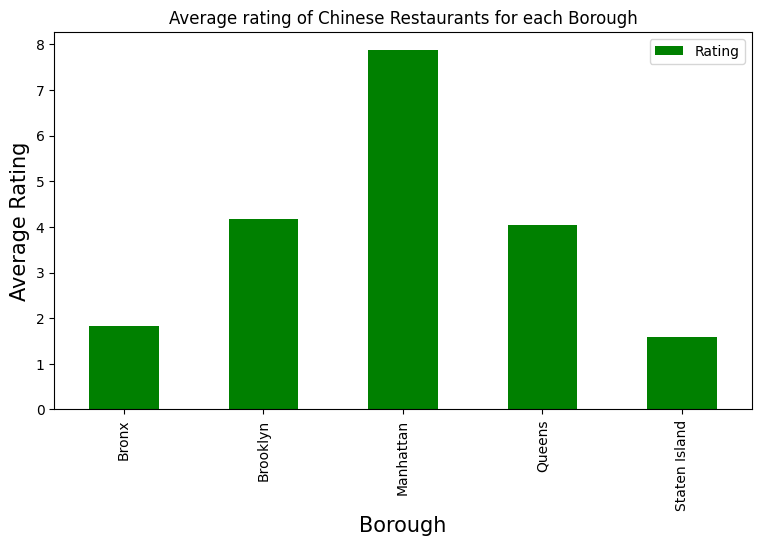

In [77]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

Let's consider all and only the neighborhoods with average rating greater or equal 8.0 to visualize on a map, since they are the best and hence the target ones for a new investor to compare with.

In [78]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
10,Boerum Hill,8.200000
18,Chelsea,9.100000
19,Chinatown,8.475000
26,College Point,8.100000
34,East Village,8.333333
37,Elmhurst,8.250000
40,Flatiron,9.100000
50,Greenwich Village,8.400000
63,Little Italy,8.600000
66,Lower East Side,8.450000


In [79]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.200000
1,Manhattan,Chelsea,40.744035,-74.003116,9.100000
2,Staten Island,Chelsea,40.594726,-74.189560,9.100000
3,Manhattan,Chinatown,40.715618,-73.994279,8.475000
4,Queens,College Point,40.784903,-73.843045,8.100000
5,Manhattan,East Village,40.727847,-73.982226,8.333333
6,Queens,Elmhurst,40.744049,-73.881656,8.250000
7,Manhattan,Flatiron,40.739673,-73.990947,9.100000
8,Manhattan,Greenwich Village,40.726933,-73.999914,8.400000
9,Manhattan,Little Italy,40.719324,-73.997305,8.600000


Now we will show this data on a map

In [80]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='orange',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [81]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

# Results

Manhattan, Brooklyn and Queens have the best rated Chinese restaurants on average. Staten Island and The Bronx have the least amount of Chinese restaurants per borough, and also the lowest rated ones on average. As expected, Chinatown in Manhattan has the highest number of Chinese restaurants in all of NY. Despite Manhattan is not the borough with the highest number of Chinese restaurants, since Queens and Brooklyn have many more restaurants, it has the highest rated restaurants.

# Conclusion

With all this information in mind, it's clear that Manhattan is by far the best location for Chinese cuisine in NYC. In order to have the best chances of success, I would open a Chinese restaurant in either Brooklyn or Queens. In fact, although they have many more Chinese restaurants with respect to Manhattan, their average ratings are low (4.0 vs 8.0 in Manhattan) and this may be an advantage for a new investor who wanna offer high-quality Chinese food. Moreover, real estate prices in Brooklyn and Queens are much cheaper than in Manhattan. Further developments would be a more in-depth analysis of real estates and venues in NYC using tools and data from other databases, not only from Foursquare, and also perform a Sentiment Analysis on restaurants' reviews in order to discover what customers really think.